# First try of BERT fine-tuning
* Used BertForSequenceClassification
* Fine-tune on tweet level, predict on author level depending on threshold
* Predict by attaching linear layer on top of the pre-trained model

# Author: David Dukić


## Import libraries

In [1]:
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForPreTraining,
    AdamW,
    BertConfig,
    get_linear_schedule_with_warmup,
)
import torch
from torch.utils.data import (
    TensorDataset,
    DataLoader,
    RandomSampler,
    SequentialSampler,
)
import torch.nn as nn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pandas as pd
import numpy as np
import emoji
from gensim.models.keyedvectors import KeyedVectors as kv
import pickle
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt

theme_bw = "theme_bw.mplstyle"
plt.style.use(theme_bw)
%matplotlib inline

path = "../"

/home/ddukic/.conda/envs/venv/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Define device

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cpu')

## Get emoji vectors

In [3]:
e2v = kv.load_word2vec_format(path + "models/emoji2vec.bin", binary=True)

## Read dataframes

In [3]:
df_train = pd.read_csv(path + "dataset/train_clean.csv", encoding="utf-8", sep=";")
df_test = pd.read_csv(path + "dataset/test_clean.csv", encoding="utf-8", sep=";")

In [5]:
df_train.head()

author_id  \
0  a8e2397021acef98cc32729cbda96910   
1  a8e2397021acef98cc32729cbda96910   
2  a8e2397021acef98cc32729cbda96910   
3  a8e2397021acef98cc32729cbda96910   
4  a8e2397021acef98cc32729cbda96910   

                                               tweet  \
0           rt #user#: i fight my battles in silence   
1  rt #user#: because telling yo business to anot...   
2                                 #user# lmao on god   
3                       glad somebody said it  #url#   
4                    i know you fucking lying  #url#   

                                         tweet_clean  \
0              rt user i fight my battles in silence   
1  rt user because telling yo business to anotha ...   
2                                   user lmao on god   
3                          glad somebody said it url   
4                       i know you fucking lying url   

                                   tweet_clean_extra     emoji  rt  user  url  \
0                      i fight my battles in silence       NaN   1     1    0   
1  because telling yo business to anotha mf aint ...       NaN   1     1    0   
2                                        lmao on god       NaN   0     1    0   
3                              glad somebody said it      😂😂😂😂   0     0    1   
4                           i know you fucking lying  😂😂😂😭😭😭😭😭   0     0    1   

   hashtag  label  
0        0      0  
1        0      0  
2        0      0  
3        0      0  
4        0      0

In [6]:
df_test.head()

author_id  \
0  ed47e83208995121ef69c686aa16ba1c   
1  ed47e83208995121ef69c686aa16ba1c   
2  ed47e83208995121ef69c686aa16ba1c   
3  ed47e83208995121ef69c686aa16ba1c   
4  ed47e83208995121ef69c686aa16ba1c   

                                               tweet  \
0  rt #user#: gang of masked bandits steals anoth...   
1  rt #user#: texas is open. mississippi is open....   
2  rt #user#: with pandemic ending, people who ye...   
3  rt #user#: hernando farmers market vendor meet...   
4  rt #user#: i got home just in time to see my s...   

                                         tweet_clean  \
0  rt user gang of masked bandits steals another ...   
1  rt user texas is open mississippi is open when...   
2  rt user with pandemic ending people who yell a...   
3  rt user hernando farmers market vendor meeting...   
4  rt user i got home just in time to see my swee...   

                                   tweet_clean_extra emoji  rt  user  url  \
0  gang of masked bandits steals another few tril...   NaN   1     1    1   
1  texas is open mississippi is open when will oh...   NaN   1     1    0   
2  with pandemic ending people who yell at others...   NaN   1     1    0   
3      hernando farmers market vendor meeting hybrid   NaN   1     1    1   
4  i got home just in time to see my sweet little...   NaN   1     1    0   

   hashtag  label  
0        0      1  
1        0      1  
2        0      1  
3        0      1  
4        0      1

## Check tweet lengths

In [7]:
pd.Series(df_train.tweet).str.split().str.len().sort_values(ascending=False).describe()

count    40000.000000
mean        12.114425
std          5.344403
min          2.000000
25%          8.000000
50%         12.000000
75%         16.000000
max         32.000000
Name: tweet, dtype: float64

# Separate into three dataframes depending on cleaning 

In [4]:
def create_clean_dfs(df):
    df_tweet = df.drop(["tweet_clean", "tweet_clean_extra"], axis=1)
    df_tweet_clean = df.drop(["tweet", "tweet_clean_extra"], axis=1)
    df_tweet_clean = df_tweet_clean.rename(columns={"tweet_clean": "tweet"})
    df_tweet_clean_extra = df.drop(["tweet", "tweet_clean"], axis=1)
    df_tweet_clean_extra = df_tweet_clean_extra.rename(
        columns={"tweet_clean_extra": "tweet"}
    )
    return {
        "original": df_tweet,
        "clean": df_tweet_clean,
        "clean_extra": df_tweet_clean_extra
    }

df = {"train": create_clean_dfs(df_train), "test": create_clean_dfs(df_test)}

## Load and prepare BERT

In [5]:
tokenizer = transformers.BertTokenizer.from_pretrained(
    "bert-base-uncased", do_lower_case=True
)
bert_model = transformers.BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

bert_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Define tokenization and feature extraction functions

In [6]:
def tokenize_tweets(df):
    input_ids = []
    attention_masks = []

    for tweet in df.tweet.values:
        encoded_dict = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            padding="max_length",
            max_length=20,
            return_attention_mask=True,
            truncation=True,
            return_tensors="pt",
        )
        input_ids.append(encoded_dict["input_ids"])
        attention_masks.append(encoded_dict["attention_mask"])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks


def create_emoji_features(df):
    author_emoji_vecs = []
    emoji_miss = 0
    emoji_total = 0
    for emojis in df.emoji:
        vector_sum = np.zeros(300)
        if emojis == emojis:
            for char in set(emoji.get_emoji_regexp().split(str(emojis).strip())):
                if char.strip():
                    try:
                        vector = e2v[char]
                        vector_sum += vector
                    except:
                        emoji_miss += 1
                    emoji_total += 1
        author_emoji_vecs.append(vector_sum)
    return author_emoji_vecs, emoji_miss, emoji_total


def create_features(df, emoji=True, indicators=True):
    authors = df.author_id.unique().tolist()
    emoji_misses_total = 0
    emoji_all = 0
    features = []
    with torch.no_grad():
        for author_id in authors:
            df_slice = df[df.author_id == author_id]
            input_ids, attention_masks = tokenize_tweets(df_slice)
            features_author = []
            for i in range(len(df_slice)):
                last_hidden_state = bert_model(
                    input_ids[i : i + 1], attention_mask=attention_masks[i : i + 1]
                )
                if emoji:
                    emoji_vecs, emoji_miss, emoji_total = create_emoji_features(
                        df_slice
                    )
                    emoji_misses_total += emoji_miss
                    emoji_all += emoji_total
                    features_author.append(
                        np.concatenate(
                            (
                                last_hidden_state[0][:, 0, :].cpu().data.numpy()[0],
                                emoji_vecs[i],
                            ),
                            axis=0,
                        )
                    )
                else:
                    features_author.append(
                        last_hidden_state[0][:, 0, :].cpu().data.numpy()[0]
                    )
            bert_emoji = np.mean(np.array(features_author), axis=0)
            if indicators:
                rt = np.array([np.mean(df_slice.rt.tolist())])
                url = np.array([np.mean(df_slice.url.tolist())])
                hashtag = np.array([np.mean(df_slice.hashtag.tolist())])
                feature_vector = np.concatenate((bert_emoji, rt, url, hashtag), axis=0)
            else:
                feature_vector = bert_emoji[:]
            features.append(feature_vector)
        if emoji:
            print("Missed emoji: ", emoji_misses_total, "/", emoji_all)
    return np.array(features)

## Load data set splits

In [7]:
def load_author_splits(split):
    with open(
        path + "final_dataset/" + split + "/" + split + "_author_id.txt", "r"
    ) as f:
        return [author.strip() for author in f.readlines()]


def filter_by_author_id(df_train, df_test):
    author_splits = {}

    for x in ["train", "valid", "test"]:
        author_splits[x] = load_author_splits(x)

    return {
        "train": df_train[df_train.author_id.isin(author_splits["train"])],
        "valid": df_train[df_train.author_id.isin(author_splits["valid"])],
        "test": df_test[df_test.author_id.isin(author_splits["test"])],
    }

## Prepare different data sets with split into train, valid, and test

In [8]:
original_splits = filter_by_author_id(df["train"]["original"], df["test"]["original"])
clean_splits = filter_by_author_id(df["train"]["clean"], df["test"]["clean"])
clean_extra_splits = filter_by_author_id(df["train"]["clean_extra"], df["test"]["clean_extra"])

## Try original splits first

In [9]:
dataloader = {}

dataset_sizes = {}

for x in ["train", "valid", "test"]:
    dataframe_x = original_splits[x][["tweet", "label"]]
    input_ids, attention_masks = tokenize_tweets(dataframe_x)
    labels = torch.tensor(dataframe_x.label.values)
    dataset_x = TensorDataset(input_ids, attention_masks, labels)
    if x == "test":
        sampler = SequentialSampler(dataset_x)
    else:
        sampler = RandomSampler(dataset_x, generator=torch.Generator().manual_seed(42))
    dataloader[x] = DataLoader(dataset_x, sampler=sampler, batch_size=4)
    dataset_sizes[x] = len(dataframe_x)

## Evaluate model

In [10]:
def evaluate(model, criterion, loader_valid):
    with torch.no_grad():
        model.eval()
        loss_valid = 0
        y_valid = []
        y_pred_valid = []

        for batch in loader_valid:
            batch_input_ids = batch[0].to(device)
            batch_attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            batch_size = batch_input_ids.size(0)

            y_valid.extend(labels.cpu().numpy())

            outputs = model(
                input_ids=batch_input_ids, attention_mask=batch_attention_mask
            )
            loss = criterion(outputs.logits, labels)

            loss_valid += loss.item() * batch_size
            
            _, y_pred = torch.max(outputs.logits, 1)
            y_pred_valid.extend(y_pred.cpu().numpy())

        accuracy = accuracy_score(y_valid, y_pred_valid)

    return loss_valid, accuracy

## Predict on unseen data

In [11]:
def get_final_prediction(predictions, threshold=0.5):
    ones = 0

    for pred in predictions:
        if pred == 1:
            ones += 1

    ones_p = ones / len(predictions)

    if ones_p >= threshold:
        return 1
    else:
        return 0
    
def predict(model, loader, threshold=0.5, tweets_per_author=200):
    with torch.no_grad():
        model.eval()
        y_pred_test = []
        y_test = []
        y_test_author = []
        y_pred_test_author = []

        tweet_author = 0

        for batch in loader:
            batch_input_ids = batch[0].to(device)
            batch_attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            batch_size = batch_input_ids.size(0)

            y_test_author.extend(labels.cpu().numpy())

            outputs = model(batch_input_ids, attention_mask=batch_attention_mask)

            _, y_pred = torch.max(outputs.logits, 1)
            y_pred_test_author.extend(y_pred.cpu().numpy())

            tweet_counter += batch_size

            if tweet_counter == tweets_per_author:
                y_test.append(list(set(y_test_author))[0])
                y_pred_test.append(get_final_prediction(y_pred_test_author, threshold))
                y_test_author = []
                y_pred_test_author = []
                tweet_counter = 0

        return y_test, y_pred_test

## Define train function

In [13]:
def train(
    model,
    optimizer,
    criterion,
    scheduler,
    epoch_num,
    dataloader,
    dataset_sizes,
    max_epochs_no_improve_tolerate=10,
):
    best_model = copy.deepcopy(model.state_dict())

    losses_train = []
    losses_valid = []
    accuracies_train = []
    accuracies_valid = []

    epochs_no_improve_counter = 0
    max_accuracy_valid = 0

    for epoch in tqdm(range(epoch_num)):
        model.train()
        loss_train = 0

        y_train = []
        y_pred_train = []

        for batch in dataloader["train"]:
            batch_input_ids = batch[0].to(device)
            batch_attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            batch_size = batch_input_ids.size(0)

            y_train.extend(labels.cpu().numpy())

            model.zero_grad()
            optimizer.zero_grad()

            outputs = model(
                input_ids=batch_input_ids, attention_mask=batch_attention_mask
            )

            loss = criterion(outputs.logits, labels)

            loss_train += loss.item() * batch_size

            _, y_pred = torch.max(outputs.logits, 1)
            y_pred_train.extend(y_pred.cpu().numpy())

            loss.backward()

            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

        scheduler.step()

        accuracy_train = accuracy_score(y_train, y_pred_train)

        loss_valid, accuracy_valid = evaluate(model, criterion, dataloader["valid"])

        print(
            "\nEpoch: ",
            epoch,
            "\t",
            "train loss: ",
            loss_train / dataset_sizes["train"],
        )
        print(
            "Epoch: ",
            epoch,
            "\t",
            "validation loss: ",
            loss_valid / dataset_sizes["valid"],
        )
        print("Epoch: ", epoch, "\t", "train accuracy: ", accuracy_train)
        print("Epoch: ", epoch, "\t", "validation accuracy: ", accuracy_valid)

        losses_train.append(loss_train / dataset_sizes["train"])
        losses_valid.append(loss_valid / dataset_sizes["valid"])
        accuracies_train.append(accuracy_train)
        accuracies_valid.append(accuracy_valid)

        if accuracy_valid > max_accuracy_valid:
            print("\n--------------------")
            print("Found better model!")
            print("--------------------")
            best_model = copy.deepcopy(model.state_dict())
            epochs_no_improve_counter = 0
            max_accuracy_valid = accuracy_valid
        else:
            epochs_no_improve_counter += 1
            if (
                epochs_no_improve_counter >= max_epochs_no_improve_tolerate
                and epoch > max_epochs_no_improve_tolerate
            ):
                print("Early stopping the training!")
                model.load_state_dict(best_model)
                return (
                    model,
                    losses_train,
                    losses_valid,
                    accuracies_train,
                    accuracies_valid,
                )

    model.load_state_dict(best_model)

    return model, losses_train, losses_valid, accuracies_train, accuracies_valid

## Prepare model and train

In [14]:
epoch_num = 200

# best lr=1e-5
optimizer = AdamW(bert_model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=epoch_num
)

In [ ]:
best_bert_model, losses_train, losses_valid, accuracies_train, accuracies_valid = train(
    bert_model, optimizer, criterion, scheduler, epoch_num, dataloader, dataset_sizes
)

## Visualize results

In [36]:
def visualize_loss(losses_train, losses_valid):
    plt.figure(num=None, figsize=(10, 10), dpi=80)
    plt.rcParams.update({"font.size": 20})
    plt.plot(losses_train, label="Train loss")
    plt.plot(losses_valid, label="Validation loss")
    plt.xlabel("Epoch number")
    plt.ylabel("Loss")
    plt.ylim([0, max(losses_train + losses_valid)])
    plt.xticks([i for i in range(0, len(losses_train) + 1, 5)])
    plt.grid(color="k", linestyle='-', linewidth=2, alpha=0.5)
    plt.legend()
    plt.show()


def visualize_accuracy(accuracies_train, accuracies_valid):
    plt.figure(num=None, figsize=(10, 10), dpi=80)
    plt.rcParams.update({"font.size": 20})
    plt.plot(accuracies_train, label="Train accuracy")
    plt.plot(accuracies_valid, label="Validation accuracy")
    plt.xlabel("Epoch number")
    plt.ylabel("Accuracy")
    plt.yticks([i / 10 for i in range(0, 11, 1)])
    plt.ylim([0, 1])
    plt.xticks([i for i in range(0, len(accuracies_train) + 1, 5)])
    plt.grid(color="k", linestyle='-', linewidth=2, alpha=0.5)
    plt.legend()
    plt.show()

## Loss

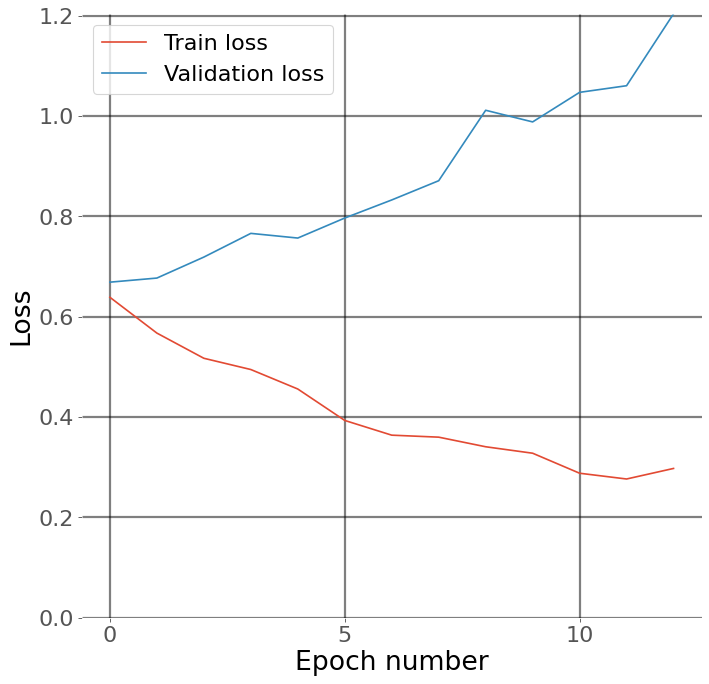

In [37]:
visualize_loss(losses_train, losses_valid)

## Accuracy

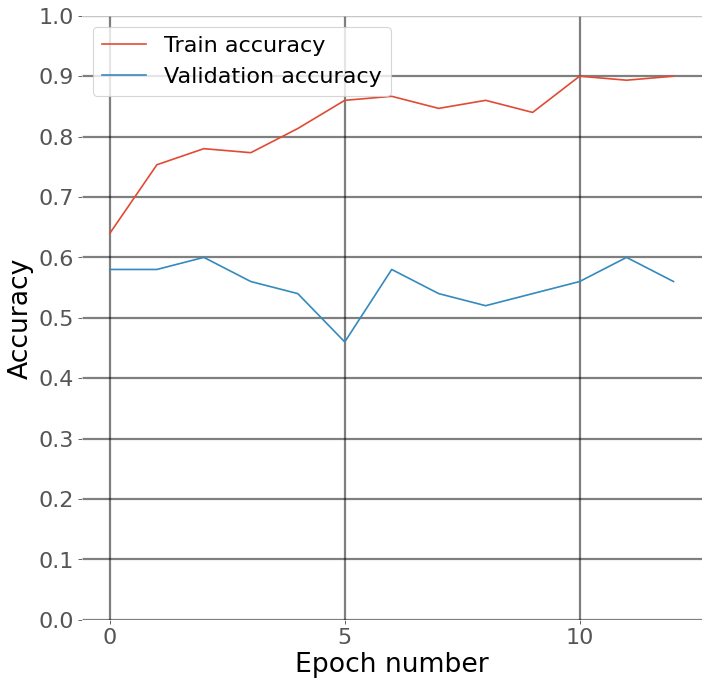

In [35]:
visualize_accuracy(accuracies_train, accuracies_valid)

## Predict on test set

In [ ]:
y_test, y_pred_test = predict(best_bert_model, dataloader["test"])

print("Precision:", precision_score(y_true=y_test, y_pred=y_pred_test))
print("Recall:", recall_score(y_true=y_test, y_pred=y_pred_test))
print("F1:", f1_score(y_true=y_test, y_pred=y_pred_test))
print("Accuracy:", accuracy_score(y_true=y_test, y_pred=y_pred_test))